## Imports

In [1]:
import time
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


## Import utility functions

In [2]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
RANDOM_SEED = 42
# LEARNING_RATE = 0.0001
BATCH_SIZE = 1704
# NUM_EPOCHS = 100

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## 1. ETL (Extract, Transform, Load)

In [5]:
df = pd.read_csv('datasets/selected_2000user_v2.csv')
df

,MeterID,DATE-Time,KWH,user
0,6200093839,2021-01-01 00:00:00,0.602,0
1,6200093839,2021-01-01 00:15:00,0.589,0
2,6200093839,2021-01-01 00:30:00,0.410,0
3,6200093839,2021-01-01 00:45:00,0.495,0
4,6200093839,2021-01-01 01:00:00,0.450,0
...,...,...,...,...
40181914,6200051044,2021-07-31 22:45:00,0.473,2000
40181915,6200051044,2021-07-31 23:00:00,0.461,2000
40181916,6200051044,2021-07-31 23:15:00,0.445,2000
40181917,6200051044,2021-07-31 23:30:00,0.460,2000


In [6]:
cluster_1 = pd.read_csv('datasets/cluster_1.csv')
len(cluster_1)

477

In [7]:
df = df[df['user'].isin(cluster_1['Series'])]
print(df['user'].nunique())
df

477


,MeterID,DATE-Time,KWH,user
0,6200093839,2021-01-01 00:00:00,0.602,0
1,6200093839,2021-01-01 00:15:00,0.589,0
2,6200093839,2021-01-01 00:30:00,0.410,0
3,6200093839,2021-01-01 00:45:00,0.495,0
4,6200093839,2021-01-01 01:00:00,0.450,0
...,...,...,...,...
40142906,6200050858,2021-07-31 22:45:00,0.000,1998
40142907,6200050858,2021-07-31 23:00:00,0.008,1998
40142908,6200050858,2021-07-31 23:15:00,0.024,1998
40142909,6200050858,2021-07-31 23:30:00,0.017,1998


## 2. EDA (Exploratory Data Analysis)

In [8]:
# Updated
def clean_data(df, user_id):
    # Select the data for the specified user
    user_data = df[df['user']==int(user_id)]

    # Drop not useful columns
    user_data['DATE-Time'] = pd.to_datetime(user_data['DATE-Time'], infer_datetime_format=True)
    user_data.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_data = user_data.set_index('DATE-Time').resample("15T").mean()
    
    # Convert the index to a DatetimeIndex object
    user_data.index = pd.to_datetime(user_data.index)

    # Count the number of zero values in each day
    zero_counts = user_data.groupby(user_data.index.floor('D'))['KWH'].apply(lambda x: (x == 0).sum())

    # Get the dates where the number of zero values is less than or equal to 48
    valid_dates = zero_counts[zero_counts <= 48].index

    # Drop the dates where the number of zero values is greater than 48
    user_data = user_data[user_data.index.floor('D').isin(valid_dates)]

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_data.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_data_clean = user_data[~user_data.index.to_series().dt.date.isin(missing_dates)]
    
    if user_data_clean.empty:
        return None

    return user_data_clean

In [9]:
random.seed(RANDOM_SEED)
# Get the list of unique user IDs in the DataFrame
unique_users = df['user'].unique().tolist()

def clean_multiple_users(df, num_users):

    # Randomly select `num_users` from the list of unique user IDs
    selected_users = random.sample(unique_users, num_users)

    # Call the clean_data() function for each selected user ID and concatenate the results
    all_users_clean = pd.concat([clean_data(df, user_id) for user_id in selected_users], axis=0)

    return all_users_clean, selected_users

In [10]:
users_clean_10, selected_users = clean_multiple_users(df, 10)

print("List of selected users: ", selected_users)
users_clean_10

List of selected users:  [1493, 257, 53, 1681, 543, 503, 471, 347, 1673, 240]


,KWH
DATE-Time,
2021-01-01 00:00:00,0.036
2021-01-01 00:15:00,0.035
2021-01-01 00:30:00,0.024
2021-01-01 00:45:00,0.011
2021-01-01 01:00:00,0.089
...,...
2021-08-31 22:45:00,0.060
2021-08-31 23:00:00,0.102
2021-08-31 23:15:00,0.251


In [11]:
type(selected_users)

list

In [12]:
# Saving list of 10 users
users_10 = pd.DataFrame(selected_users ,columns=["user"]).sort_values(by="user").reset_index()
users_10 = users_10.drop(columns=["index"])

In [13]:
users_10

,user
0,53
1,240
2,257
3,347
4,471
5,503
6,543
7,1493
8,1673
9,1681


In [14]:
# users_10.to_csv('datasets/users_10.csv', index=False)

In [15]:
# all_users_clean.to_csv('datasets/100_users_clean.csv', index=False) 

In [16]:
# user_6 = clean_data(df, 6)
# user_6

In [17]:
# plt.figure(figsize=(12,4))
# plt.title('(Energy Consumptions)', size=15)
# plt.ylabel('KWH')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# plt.plot(user_6['KWH'])
# plt.show()

## 3. Prepare the data

In [18]:
def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    # Here we're adding an extra dimension to the data to represent the features, which is 1 in our case
    windowed_data = np.reshape(data, (num_windows, window_size))
    
    return windowed_data

# Example usage
window_size = 96
data = users_clean_10.to_numpy()
windowed_data = create_windowed_dataset(data, window_size)
print(f" Window shape : {windowed_data.shape}")
print(f" Type of Window : {type(windowed_data)}")

 Window shape : (1894, 96)
 Type of Window : <class 'numpy.ndarray'>


The shape of the dataset (for selected `User_1`) is `(329, 96)` which means: 
* we have `329` samples `(i.e., 329 non-overlapping windows)`,
* each window has `96` time steps `(i.e., 96 data points)`,
* and `1` feature `(i.e., KWH)`.

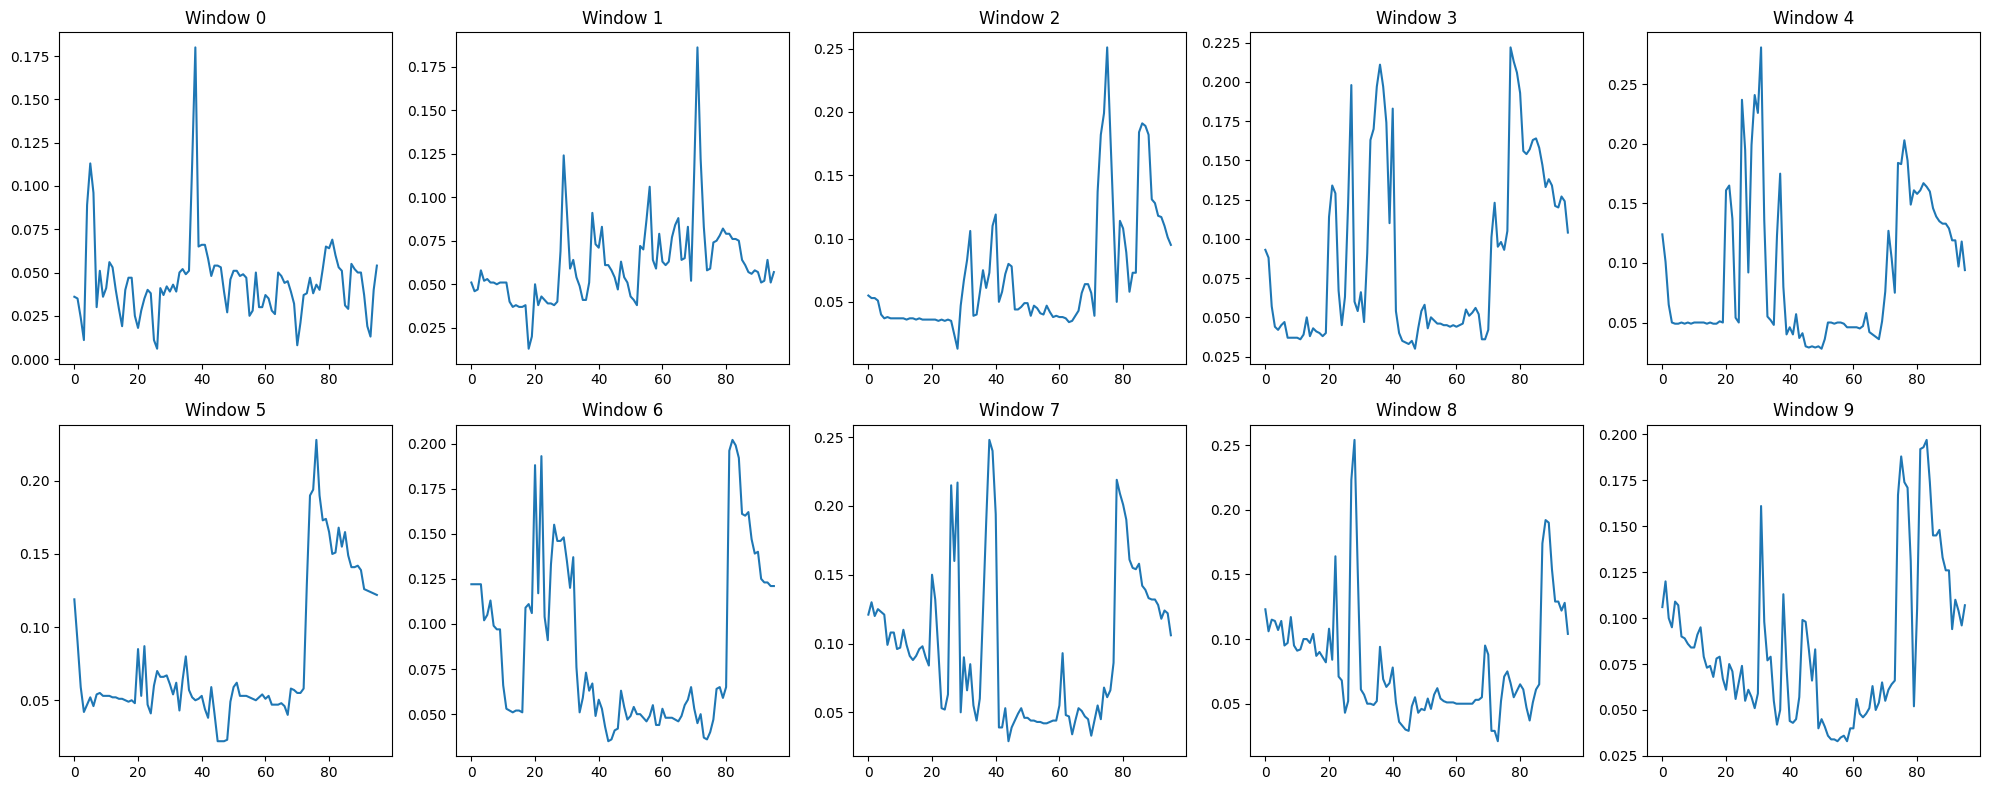

In [19]:
# Plot the first 10 windows
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.plot(windowed_data[i])
    ax.set_title(f"Window {i}")
plt.tight_layout()
plt.show()

### Divide the data into train, validation, and test sets

We'll split the examples into train, validation and test sets:

In [20]:
# Divide the data into training, validation, and test sets 
train_data, val_data = train_test_split(windowed_data, test_size=0.10, shuffle=True, random_state=RANDOM_SEED)
val_data, test_data = train_test_split(val_data, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1704, 96)
(95, 96)
(95, 96)


We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [21]:
def create_dataset(df):
    sequences = df.astype(np.float32).tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (96x1 in our case).

Let's create some datasets:

In [22]:
train_dataset, seq_len, n_features = create_dataset(train_data)
val_dataset, _, _ = create_dataset(val_data)
test_normal_dataset, _, _ = create_dataset(test_data)

### 4. Define the model

This model takes in a tensor of shape `(batch_size, sequence_length, num_features)` as input and outputs a tensor of the same shape. 

We use `Conv1d` layers for the encoder and `ConvTranspose1d` layers for the decoder.

Note that the number of input channels for the first Conv1d layer is 1, because we are using a univariate time series as input. 

If you had a multivariate time series, you would set the number of input channels to the number of features in your data.

You can adjust the number of channels and the kernel sizes of the convolutional layers to increase or decrease the complexity of the model.

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

We'll use the LSTM Autoencoder from this GitHub repo with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the Encoder:

In [23]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True,
          dropout = 0.2
        )
        
        self.relu2 = nn.ReLU()
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True,
          dropout = 0.2
        )

    def forward(self, x):
        # print(f"ENCODER============")
        x = x.reshape((1, self.seq_len, self.n_features))
        # print(f"x reshape: {x.shape}")
        
        x = self.relu1(x)
        x, (_, _) = self.rnn1(x)
        # print(f"x of rnn1 : {x.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, _) = self.rnn2(x)
        # print(f"x of rnn2 : {x.shape}")
        # print(f"hidden_n of rnn2 : {hidden_n.reshape((self.n_features, self.embedding_dim)).shape}")

        return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder:

In [24]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=128, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.linear = nn.Linear(128, 128)
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True,
          dropout = 0.2
        )
        
        self.relu2 = nn.ReLU()

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True,
          dropout = 0.2
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        # print(f"DECODER============")
        x = x.repeat(self.seq_len, self.n_features)
        # print(f"x repeat : {x.shape}")
        
        x = x.reshape((self.n_features, self.seq_len, 128))
        # print(f"x reshape : {x.shape}")
        
        x = self.linear(x)
        # print(f"x linear reshape : {x.shape}")
        
        x = self.relu1(x)
        x, (hidden_n, cell_n) = self.rnn1(x)
        # print(f"x of rnn1 : {x.shape}")
        # print(f"hidden_n of rnn1 : {hidden_n.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        # print(f"x of rnn2 : {x.shape}")
        # print(f"hidden_n of rnn2 : {hidden_n.shape}")
        
        x = x.reshape((self.seq_len, self.hidden_dim))
        # print(f"x reshape : {x.shape}")

        return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [25]:
class VAE_LSTM(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(VAE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        
        self.z_mean = torch.nn.Linear(128, 128).to(device)
        self.z_log_var = torch.nn.Linear(128, 128).to(device)
        self.softplus = torch.nn.Softplus() # added
        
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        # print(f"xshape: {x.shape}")
        
        mean, std = self.z_mean(x), self.z_log_var(x)
        # print(f"{mean=}")
        # print(f"{std=}")
        
        #the softplus function to convert the log variance output from the linear layer to a positive value
        std = self.softplus(std)
        
        encoded = self.reparameterize(mean, std)
        # print(encoded.shape)
        
        x = self.decoder(encoded)
        # print(x.shape)

        return x, encoded, mean, std

The input shape for `Conv1d` should be `(batch_size, num_features, sequence_length)`. 

In our case, the batch size is determined by the batch_size argument in the `DataLoader`, the number of features is `1`, and the sequence length is the window size which is `96`. 

So, the shape of each input should be `(batch_size, 1, 96)`.

---

If we use `Conv2d` instead of `Conv1d`, the input shape should be `(batch_size, 1, window_size, 1)` instead of `(batch_size, window_size, 1)`.

This is because `Conv2d` expects a 4D tensor where the second dimension represents the number of channels. 

In our case, we only have one channel, so we set this dimension to `1`. The fourth dimension is set to 1 because we only have one feature.

---

If you want to use `Conv1d`, then the shape of the input tensor should be `(batch_size, in_channels, sequence_length)`, where `in_channels` is 1 in your case since you have a single feature. 

So for your specific case, the shape of the input tensor should be `(batch_size, 1, window_size)`, where `window_size` is 96.

However, if you decide to use `Conv2d`, then the shape of the input tensor should be `(batch_size, in_channels, height, width)`. 

Since you only have one feature, the `in_channels` would still be 1. 

You can choose the `height` and `width` of the input tensor based on the window size and how you want to shape the data for the convolutional layers. 

For example, you could set `height=1` and `width=window_size`, or you could set `height=window_size` and `width=1`

### Define loss and optimization functions

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [26]:
model = VAE_LSTM(seq_len, n_features, 128)
model = model.to(device)

In [27]:
model

VAE_LSTM(
  (encoder): Encoder(
    (relu1): ReLU()
    (rnn1): LSTM(1, 256, batch_first=True, dropout=0.2)
    (relu2): ReLU()
    (rnn2): LSTM(256, 128, batch_first=True, dropout=0.2)
  )
  (z_mean): Linear(in_features=128, out_features=128, bias=True)
  (z_log_var): Linear(in_features=128, out_features=128, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (relu1): ReLU()
    (rnn1): LSTM(128, 128, batch_first=True, dropout=0.2)
    (relu2): ReLU()
    (rnn2): LSTM(128, 256, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [28]:
## Not use in current Task
# set_all_seeds(RANDOM_SEED)

# model = VAE()
# model.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# model

In [29]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1024
262144
  1024
  1024
131072
 65536
   512
   512
 16384
   128
 16384
   128
 16384
   128
 65536
 65536
   512
   512
131072
262144
  1024
  1024
   256
     1
______
1040001


In [30]:
from pynvml import *
gb = pow(1024,3)
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

h = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(h)
print(f'\ntotal    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

total    : 47.99 GB
free     : 14.35 GB
used     : 33.64 GB

total    : 11.00 GB
free     : 10.91 GB
used     : 0.09 GB


In [31]:
# for seq, y_train in train_data:
#     print(seq)
#     print(y_train)
#     break

### Train the model

Let's write a helper function for our training process:

In [32]:
import pickle

# Modified VAE train_model function!!!!!!
def train_model(model, train_dataset, val_dataset, n_epochs, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[],
                   val=[], 
                   reconstruction_loss=[], 
                   kl_loss=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    num_epochs_without_improvement = 0  # initialize early stopping counter
    
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        reconstruction_losses=[]
        kl_losses=[]
        
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            # FORWARD AND BACK PROP
            seq_true = seq_true.to(device)
            seq_pred, encoded, mean, std = model(seq_true)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

            reconstruction_loss = criterion(seq_pred, seq_true)
            
            loss = (1*reconstruction_loss) + kl_div
            
            loss.backward()
            
            # UPDATE MODEL PARAMETERS
            optimizer.step()
            
            # HISTORY
            train_losses.append(loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            kl_losses.append(kl_div.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred, encoded, mean, std = model(seq_true)

                # total loss = reconstruction loss + KL divergence
                #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
                kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

                reconstruction_loss = criterion(seq_pred, seq_true)
            
                loss = (1*reconstruction_loss) + kl_div
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        reconstruction_loss = np.mean(reconstruction_losses)
        kl_loss = np.mean(kl_losses)
        val_loss = np.mean(val_losses)
        

        history['train'].append(train_loss)
        history['reconstruction_loss'].append(reconstruction_loss)
        history['kl_loss'].append(kl_loss)
        history['val'].append(val_loss)
        
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            #Save model
            MODEL_PATH = 'model/Final_VAE_10u_v3.pth'
            torch.save(model, MODEL_PATH)


            # save dictionary to person_data.pkl file
            with open('history/Final_VAE_10u_v3.pkl', 'wb') as fp:
                pickle.dump(history, fp)
                print('History dictionary saved successfully to file')
            
            num_epochs_without_improvement = 0  # reset early stopping counter
        else:
            num_epochs_without_improvement += 1
            if num_epochs_without_improvement >= patience:
                print(f"No improvement after {patience} epochs, stopping early")
                break
            else:
                print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss} (no improvement {num_epochs_without_improvement})')
        

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    model.load_state_dict(best_model_wts)
    return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

### Evaluation

In [33]:
model, history = train_model(
    model, 
    train_dataset, 
    val_dataset, 
    n_epochs=250, 
    patience=250,
)

Time elapsed: 0.41 min
History dictionary saved successfully to file
Epoch 1: train loss 11.450899132120778 val loss 10.869073789998104
Time elapsed: 0.81 min
History dictionary saved successfully to file
Epoch 2: train loss 10.500700176881512 val loss 10.759452034297743
Time elapsed: 1.21 min
Epoch 3: train loss 10.474989520552013 val loss 10.80237778111508 (no improvement 1)
Epoch 3: train loss 10.474989520552013 val loss 10.80237778111508
Time elapsed: 1.61 min
History dictionary saved successfully to file
Epoch 4: train loss 10.459349869282592 val loss 10.69617227002194
Time elapsed: 2.02 min
History dictionary saved successfully to file
Epoch 5: train loss 10.450157263749082 val loss 10.692764580877204
Time elapsed: 2.42 min
History dictionary saved successfully to file
Epoch 6: train loss 10.428234809021435 val loss 10.668972406889264
Time elapsed: 2.82 min
Epoch 7: train loss 10.405137733744343 val loss 10.694347492017243 (no improvement 1)
Epoch 7: train loss 10.405137733744343

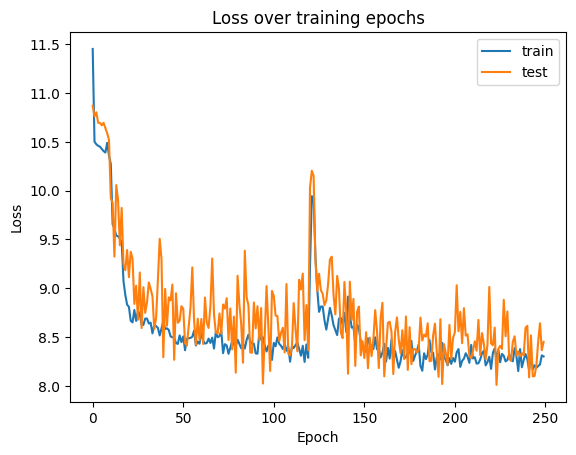

In [34]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

### Saving the model

Let's store the model for later use:

In [35]:
MODEL_PATH = 'model/Final_VAE_10u_v3.pth'

torch.save(model, MODEL_PATH)

### Saving a history to file

In [36]:
import pickle

# save dictionary to person_data.pkl file
with open('history/Final_VAE_10u_v3.pkl', 'wb') as fp:
    pickle.dump(history, fp)
    print('History dictionary saved successfully to file')

History dictionary saved successfully to file


### Load Model

Uncomment the next lines, if you want to download and load the pre-trained model:

In [38]:
# model = torch.load('model/Final_VAE_10u_v3.pth')
# model = model.to(device)

### Load History

In [39]:
# import pickle

# # Read dictionary pkl file
# with open('history/Final_VAE_10u_v3.pkl', 'rb') as fp:
#     history = pickle.load(fp)
#     print('History dictionary')
#     print(history.keys())

History dictionary
dict_keys(['train', 'val', 'reconstruction_loss', 'kl_loss'])


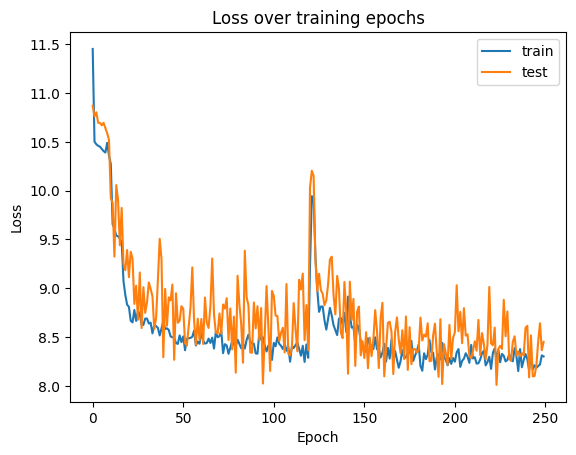

In [37]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

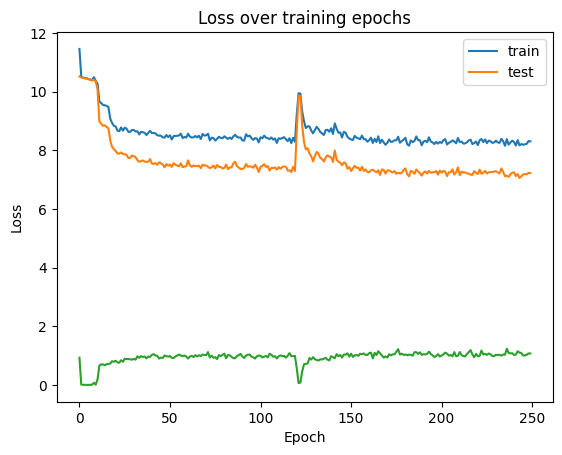

In [38]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['reconstruction_loss'])
ax.plot(history['kl_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

### Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [39]:
def predict(model, dataset):
    predictions, losses, abs_errs = [], [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred, encoded, mean, std = model(seq_true)

            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

            reconstruction_loss = criterion(seq_pred, seq_true)
            
            loss = reconstruction_loss + kl_div
            
            abs_err = np.abs((seq_true.detach().cpu().numpy() - seq_pred.detach().cpu().numpy())/seq_pred.detach().cpu().numpy())

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
            abs_errs.append(abs_err.sum())
            
    return predictions, losses, abs_errs, encoded, mean, std

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

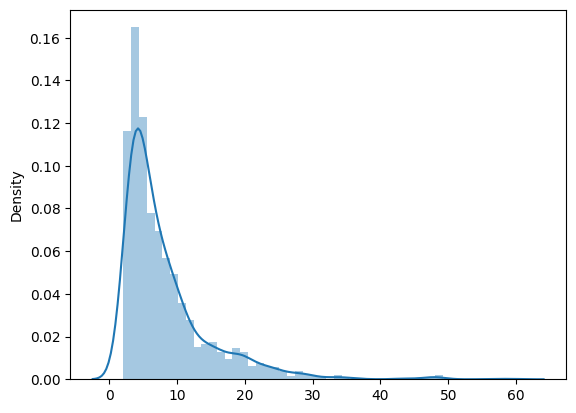

In [40]:
_, losses, abs_errs, _, mean, std = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [42]:
mean.mean(), std.mean()

(tensor(0.0017, device='cuda:0'), tensor(6.2971e-06, device='cuda:0'))

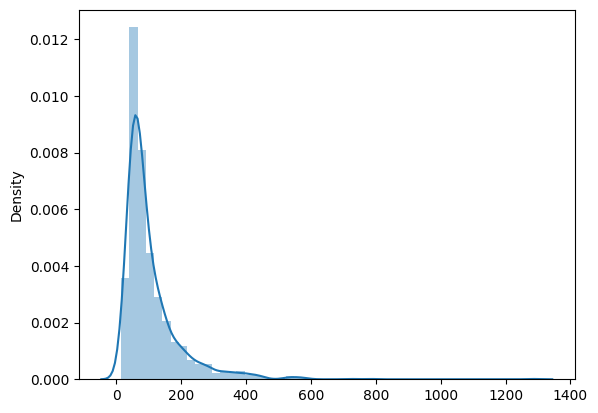

In [43]:
sns.distplot(abs_errs, bins=50, kde=True);

In [48]:
THRESHOLD_losses = 15
THRESHOLD_abs_errs = 150

## Predict Test datasets

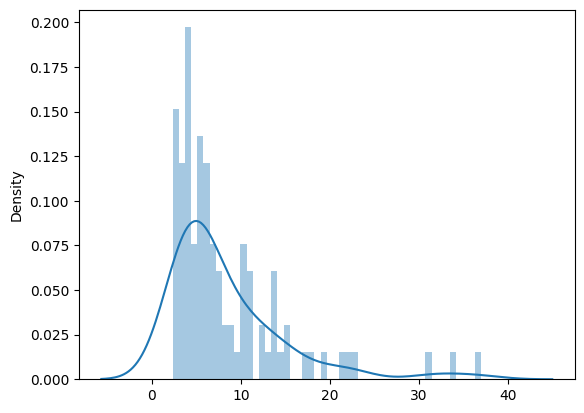

In [49]:
predictions, pred_losses, pred_abs_errs, _, pred_mean, pred_std = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

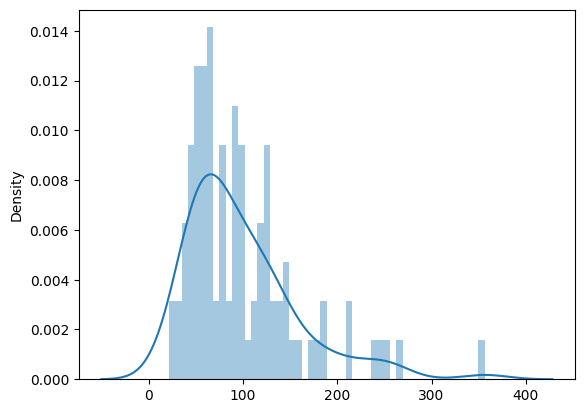

In [50]:
sns.distplot(pred_abs_errs, bins=50, kde=True);

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

* If `the reconstruction loss` for an example is below the threshold, we'll classify it as a normal usesages
* Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

* If `the absolute errors` for an example is below the threshold, we'll classify it as a normal usesages
* Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal energy consumption

Let's check how well our model does on normal datasets. We'll use the normal datasets from the test set (our model haven't seen those):

We'll count the correct predictions:

In [51]:
correct = sum(l <= THRESHOLD_losses for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 84/95


In [52]:
correct_errs = sum(l <= THRESHOLD_abs_errs for l in pred_abs_errs)
print(f'Correct normal predictions: {correct_errs}/{len(test_normal_dataset)}')

Correct normal predictions: 83/95


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal datasets:

We can add this type of theif attacks

In [53]:
# anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

In [54]:
# predictions, pred_losses = predict(model, anomaly_dataset)
# sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [55]:
def plot_prediction(data, model, title, ax, random_state=None):
    predictions, pred_losses, pred_abs_errs,_, pred_mean, pred_std = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (Relative Error: {np.round(pred_abs_errs[0], 2):.2f})')
    ax.grid(True)
    ax.set_xlim(0, len(test_normal_dataset[1])-1)
    
    ax.legend()

In [56]:
def plot_mse(data, model, ax, random_state=None):
    predictions, pred_losses, pred_abs_errs,_, pred_mean, pred_std = predict(model, [data])
    
    mses = np.abs(data.T[0] - predictions[0])
    # print(mses.shape)         #-> torch.Size([96])
    ax.imshow(np.atleast_2d(mses), aspect=4, cmap='Reds')
    ax.set_title(f'Relative Error')
    ax.set_xticks([])
    ax.set_yticks([])

In [57]:
def plot_reconstructed_probability(data, model, ax, random_state=None):
    predictions, _, _, _, pred_mean, pred_std = predict(model, [data])
    
    mean = pred_mean.mean().cpu().numpy()
    std = pred_std.mean().cpu().numpy()
    log_prob = -0.5 * ((data.T[0] - mean) / std) ** 2 - np.log(std) - 0.5 * np.log(2 * np.pi)
    # print(log_prob.shape)     #-> torch.Size([96])
    ax.imshow(np.atleast_2d(log_prob), aspect=4, cmap='Reds_r')
    ax.set_title(f'Reconstructed Probability')
    ax.set_xticks([])
    ax.set_yticks([])

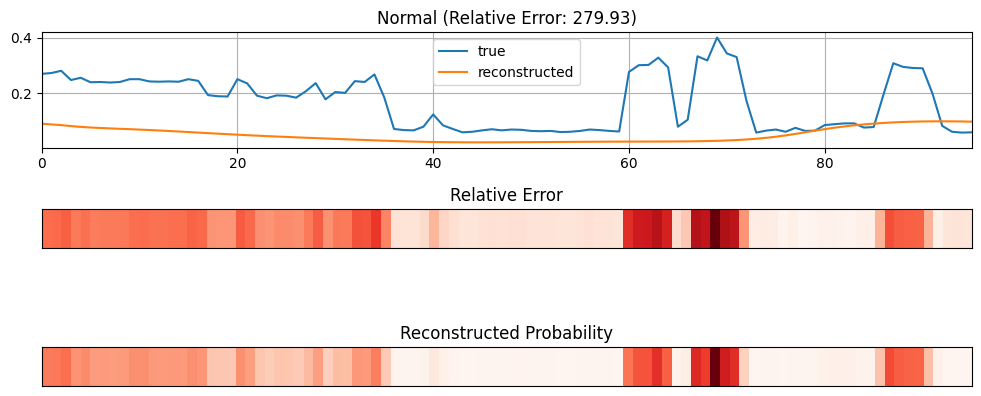

In [68]:
# Looking at ONE sample
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
fig.subplots_adjust(top=0.6)

data = test_normal_dataset[14]

plot_prediction(data, model, title='Normal', ax=axs[0], random_state=42)
plot_mse(data, model, ax=axs[1], random_state=42)
plot_reconstructed_probability(data, model, ax=axs[2], random_state=42)

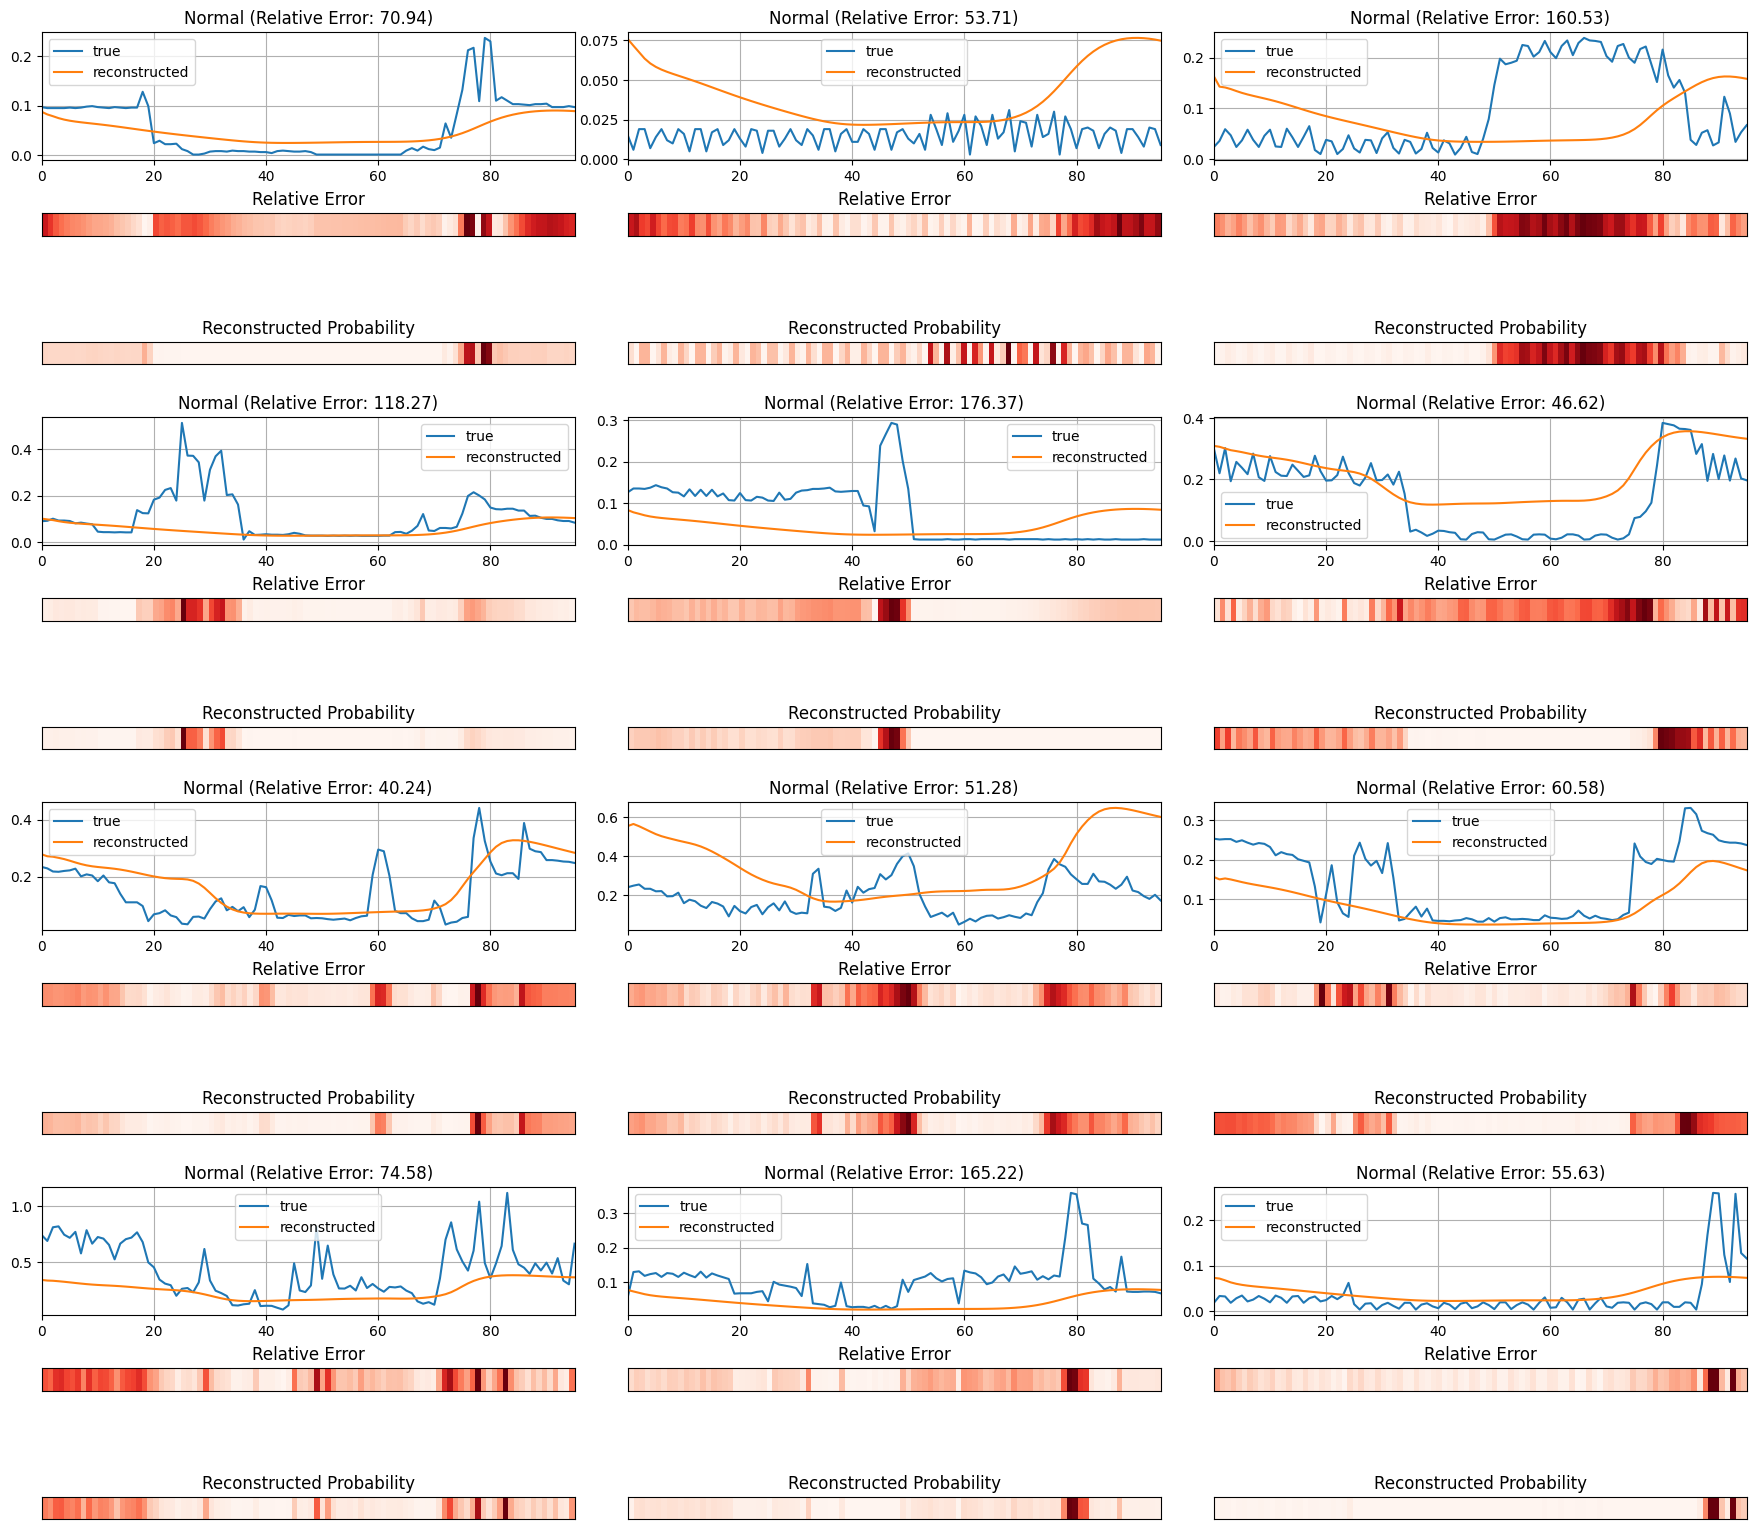

In [69]:
# Looking at MANY samples
numberofloop = 4

fig, axs = plt.subplots(nrows=3*numberofloop, ncols=3, figsize=(22, 20))
fig.subplots_adjust(hspace=0.0) # set the vertical space between subplots
fig.subplots_adjust(wspace=0.1) # set the horizontal space between subplots

for i, data in enumerate(train_dataset[0:3]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i], random_state=42)
    plot_mse(data, model, ax=axs[1, i], random_state=42)
    plot_reconstructed_probability(data, model, ax=axs[2, i], random_state=42)
    
for i, data in enumerate(train_dataset[3:6]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i], random_state=42)
    plot_mse(data, model, ax=axs[4, i], random_state=42)
    plot_reconstructed_probability(data, model, ax=axs[5, i], random_state=42)
    
for i, data in enumerate(train_dataset[7:10]):
    plot_prediction(data, model, title='Normal', ax=axs[6, i], random_state=42)
    plot_mse(data, model, ax=axs[7, i], random_state=42)
    plot_reconstructed_probability(data, model, ax=axs[8, i], random_state=42)
    
for i, data in enumerate(train_dataset[11:14]):
    plot_prediction(data, model, title='Normal', ax=axs[9, i], random_state=42)
    plot_mse(data, model, ax=axs[10, i], random_state=42)
    plot_reconstructed_probability(data, model, ax=axs[11, i], random_state=42)

### Testing

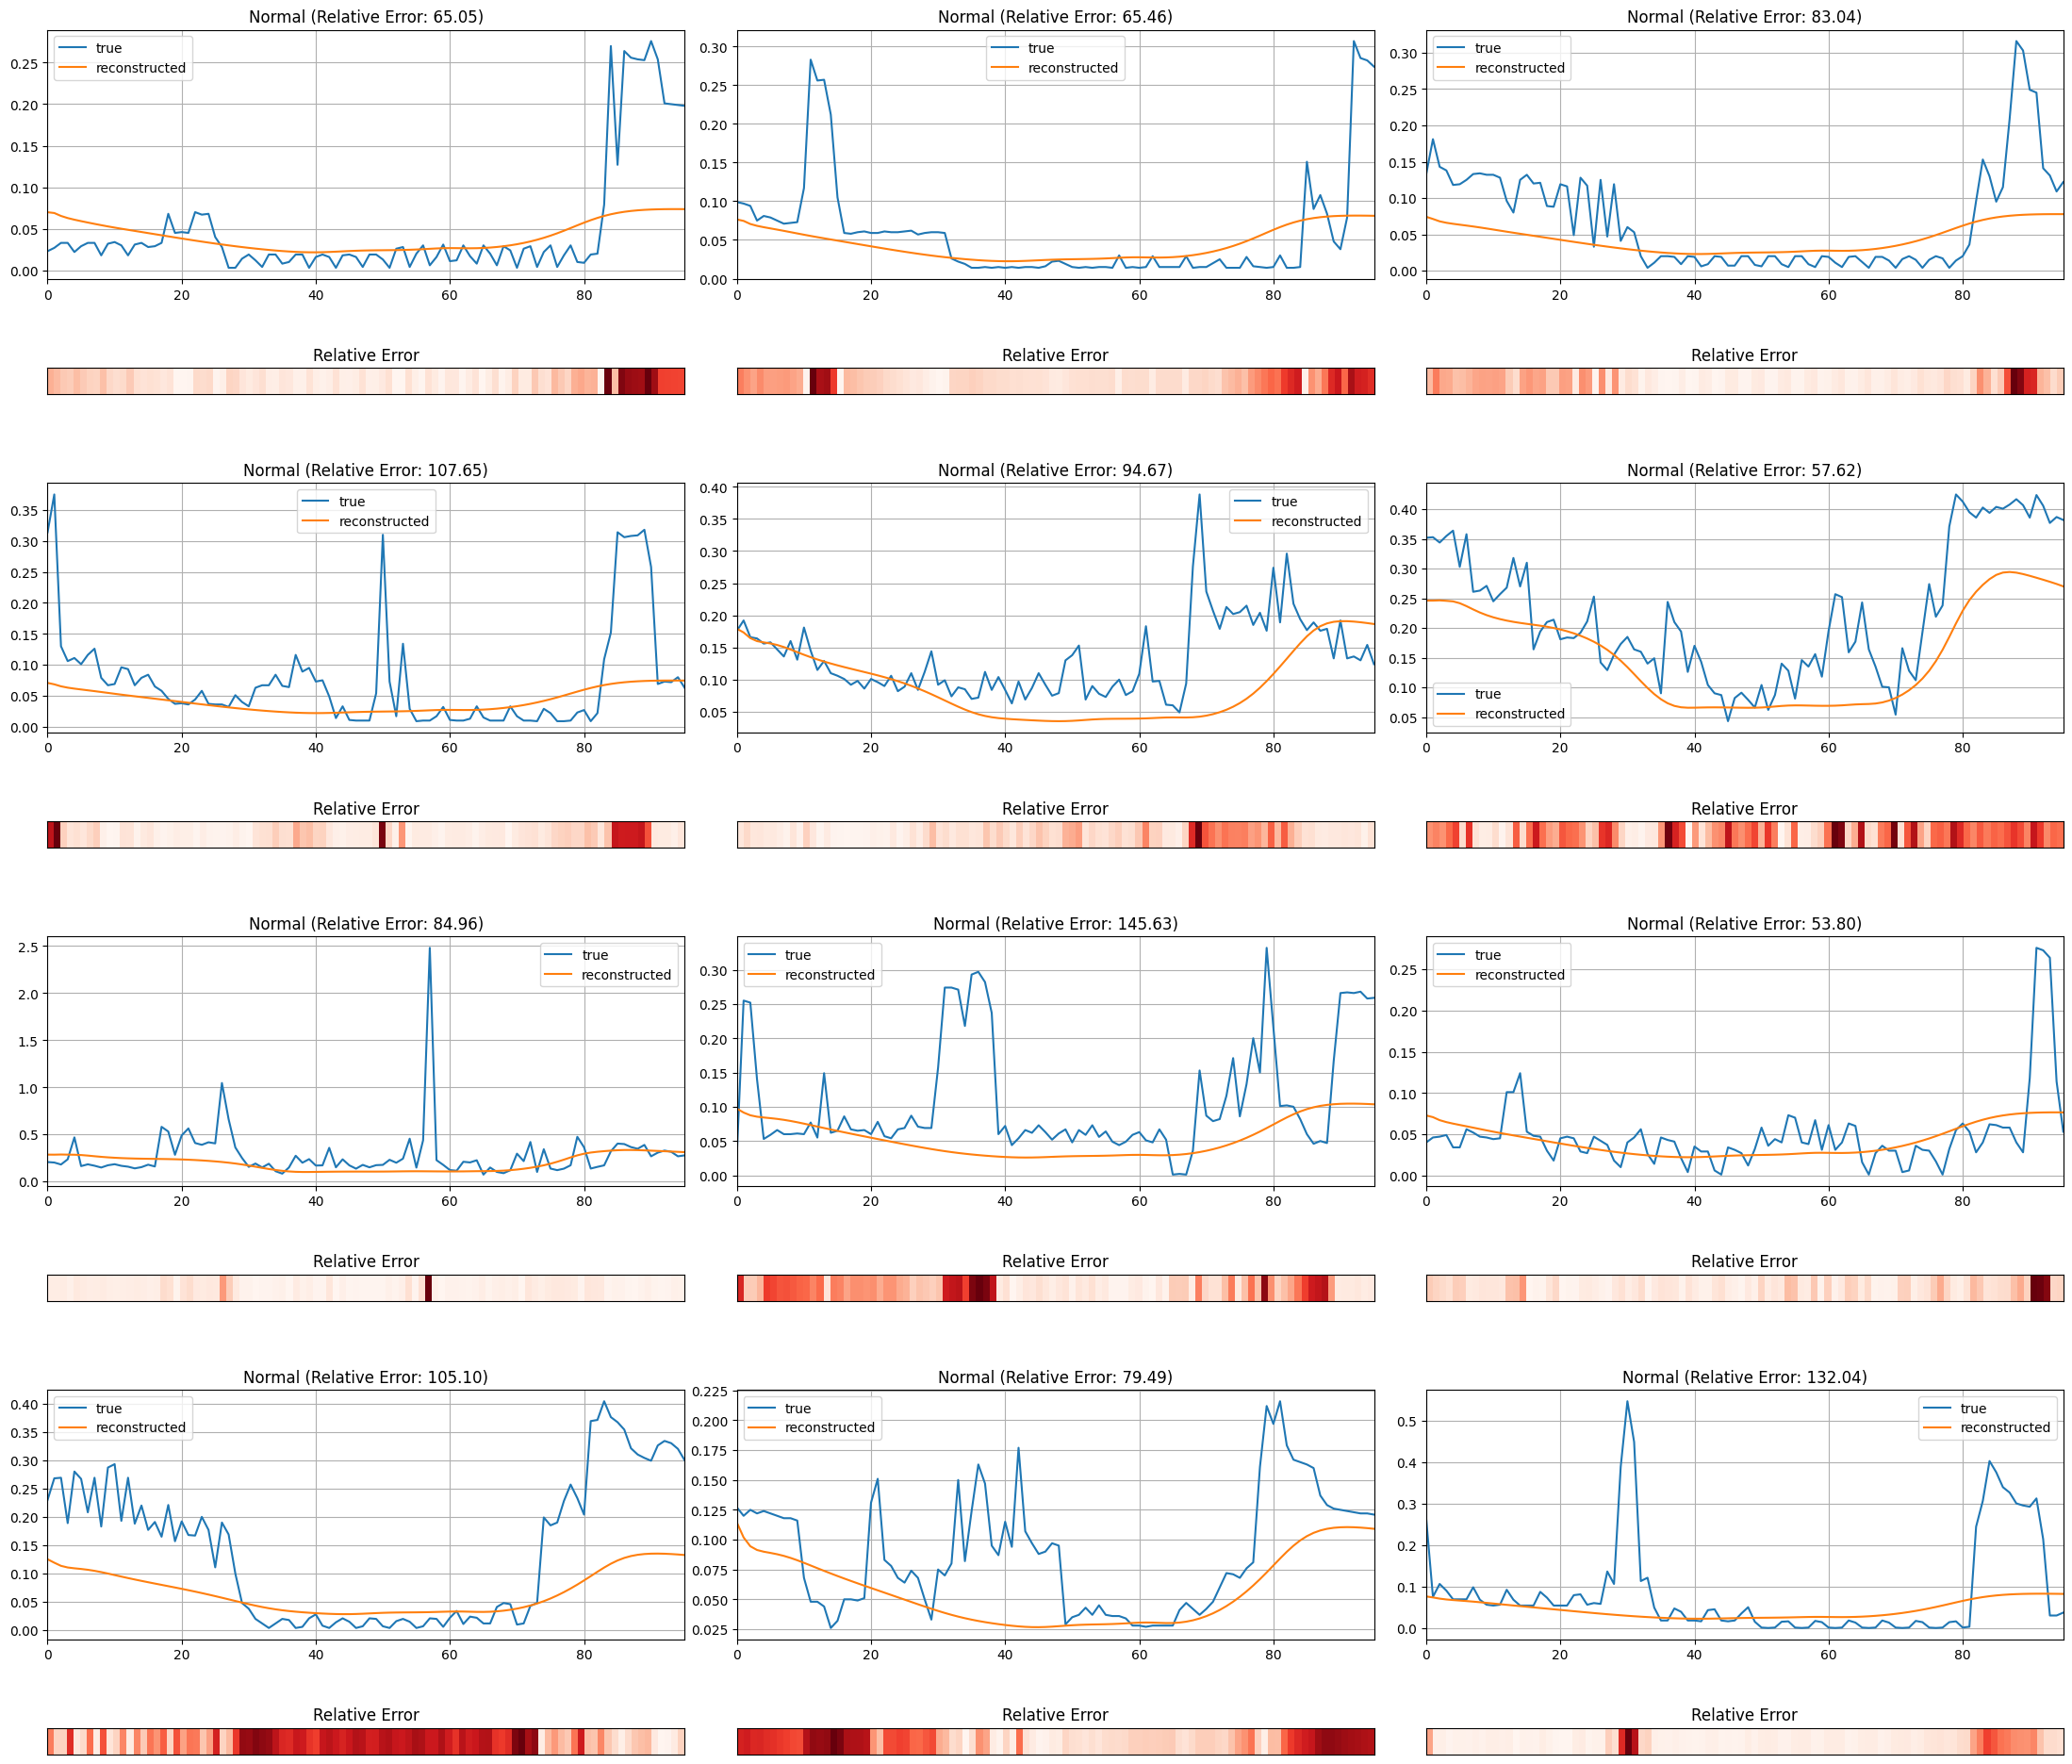

In [428]:
# In Testing
numberofloop = 4

fig, axs = plt.subplots(nrows=2*numberofloop, ncols=3, figsize=(22, 20))
fig.subplots_adjust(hspace=0.0) # set the vertical space between subplots
fig.subplots_adjust(wspace=0.1) # set the horizontal space between subplots

for i, data in enumerate(test_normal_dataset[0:3]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i], random_state=42)
    plot_mse(data, model, ax=axs[1, i], random_state=42)
    
for i, data in enumerate(test_normal_dataset[3:6]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i], random_state=42)
    plot_mse(data, model, ax=axs[3, i], random_state=42)
    
for i, data in enumerate(test_normal_dataset[7:10]):
    plot_prediction(data, model, title='Normal', ax=axs[4, i], random_state=42)
    plot_mse(data, model, ax=axs[5, i], random_state=42)
    
for i, data in enumerate(test_normal_dataset[11:14]):
    plot_prediction(data, model, title='Normal', ax=axs[6, i], random_state=42)
    plot_mse(data, model, ax=axs[7, i], random_state=42)

plt.tight_layout()

### Test

## 5. Evaluate the model using the test set

# Task

### VAE autocoder
* https://www.google.com/search?q=variational+autoencoder+based+anomaly+detection+using+reconstruction+probability+github&rlz=1C5CHFA_enTH999TH999&oq=Variational+Autoencoder+based+Anomaly+Detection+using+Reconstruction+Probability+&aqs=chrome.1.69i57j0i512j69i60.3070j0j7&sourceid=chrome&ie=UTF-8
* https://github.com/Michedev/VAE_anomaly_detection
* https://github.com/smile-yan/vae-anomaly-detection
* https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py


### CNN
* https://github.com/khanmhmdi/Cifar-Image-Reconstruction-using-Autoencoder-Models/blob/main/Image_reconstruction.ipynb
* https://github.com/ebrahimpichka/conv-autoencoder (test on this now!!)

### Test with Cluster 2

In [72]:
df = pd.read_csv('datasets/selected_2000user_v2.csv')
df

,MeterID,DATE-Time,KWH,user
0,6200093839,2021-01-01 00:00:00,0.602,0
1,6200093839,2021-01-01 00:15:00,0.589,0
2,6200093839,2021-01-01 00:30:00,0.410,0
3,6200093839,2021-01-01 00:45:00,0.495,0
4,6200093839,2021-01-01 01:00:00,0.450,0
...,...,...,...,...
40181914,6200051044,2021-07-31 22:45:00,0.473,2000
40181915,6200051044,2021-07-31 23:00:00,0.461,2000
40181916,6200051044,2021-07-31 23:15:00,0.445,2000
40181917,6200051044,2021-07-31 23:30:00,0.460,2000


In [73]:
cluster_2 = pd.read_csv('datasets/cluster_2.csv')
len(cluster_2)

340

In [74]:
df = df[df['user'].isin(cluster_2['Series'])]
print(df['user'].nunique())
df

340


,MeterID,DATE-Time,KWH,user
21048,6200093048,2021-01-01 00:00:00,0.022,1
21049,6200093048,2021-01-01 00:15:00,0.028,1
21050,6200093048,2021-01-01 00:30:00,0.047,1
21051,6200093048,2021-01-01 00:45:00,0.046,1
21052,6200093048,2021-01-01 01:00:00,0.043,1
...,...,...,...,...
40162378,6200051042,2021-07-31 22:45:00,0.113,1999
40162379,6200051042,2021-07-31 23:00:00,0.103,1999
40162380,6200051042,2021-07-31 23:15:00,0.097,1999
40162381,6200051042,2021-07-31 23:30:00,0.118,1999


In [85]:
selected_users_cluster2 = clean_data(df, 2)
selected_users_cluster2

,KWH
DATE-Time,
2021-01-01 00:00:00,0.037
2021-01-01 00:15:00,0.038
2021-01-01 00:30:00,0.038
2021-01-01 00:45:00,0.038
2021-01-01 01:00:00,0.038
...,...
2021-08-31 22:45:00,0.140
2021-08-31 23:00:00,0.132
2021-08-31 23:15:00,0.136


In [86]:
data_cluter2 = selected_users_cluster2.to_numpy()
windowed_data_cluster2 = create_windowed_dataset(data_cluter2, window_size)
print(f" Window shape : {windowed_data_cluster2.shape}")
print(f" Type of Window : {type(windowed_data_cluster2)}")

 Window shape : (216, 96)
 Type of Window : <class 'numpy.ndarray'>


In [87]:
cluster2_dataset, _, _ = create_dataset(windowed_data_cluster2)

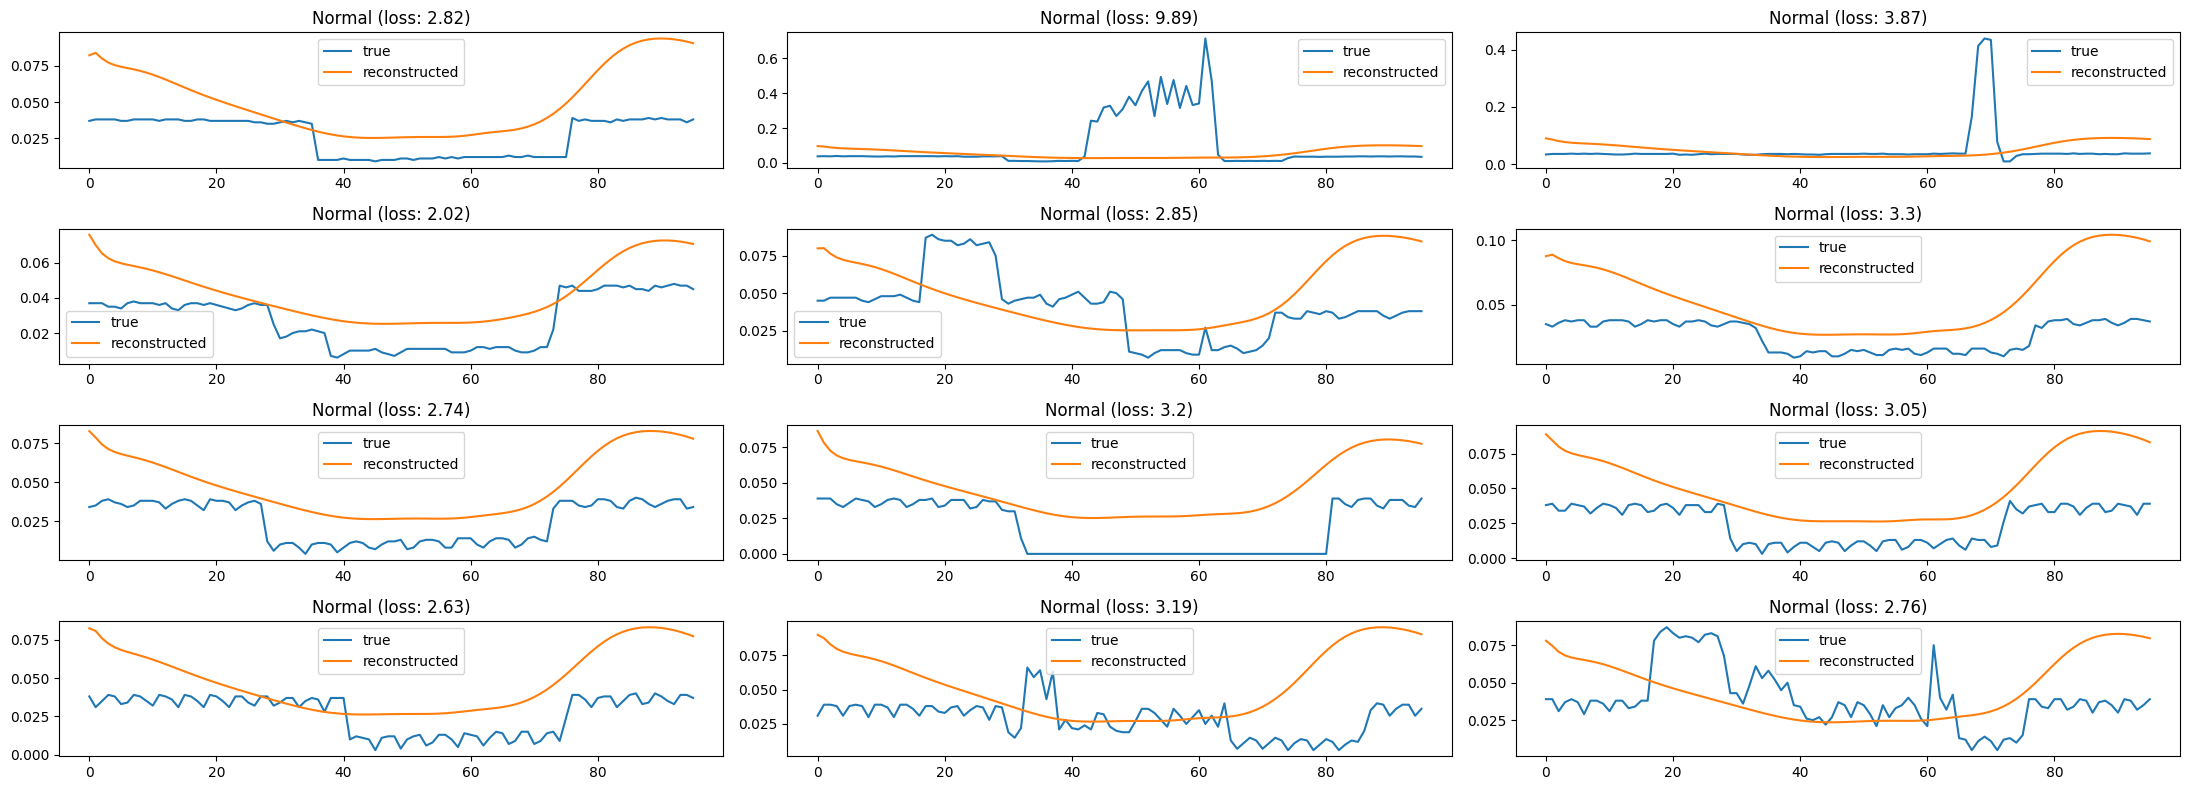

In [88]:
# In Testing Cluster2
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(cluster2_dataset[0:3]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(cluster2_dataset[3:6]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(cluster2_dataset[6:9]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(cluster2_dataset[9:12]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

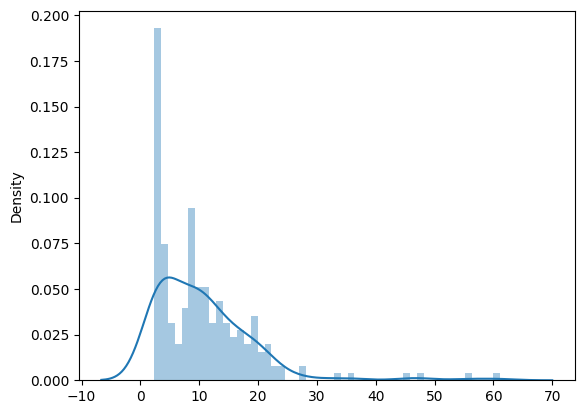

In [89]:
predictions, pred_losses, _, _, _ = predict(model, cluster2_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
fig, ax = plt.subplots(
  nrows=2,
  ncols=1,
  # sharey=True,
  # sharex=True,
  figsize=(15, 6)
)

predictions, pred_losses, _,_,_ = predict(model, [cluster2_dataset[1]])

mse = np.abs((cluster2_dataset[1].T[0] - predictions[0])/predictions[0])

ax[0].plot(cluster2_dataset[1], label='true')
ax[0].plot(predictions[0], label='reconstructed')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(0, len(cluster2_dataset[1])-1)

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['lime', 'crimson'])
# ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Wistia', vmin=0, vmax=0.1)
ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Reds')
ax[1].set_xticks([])
ax[1].set_yticks([])

# ax[2].imshow(np.atleast_2d(prop.cpu()), aspect=5, cmap='Reds')

# plt.savefig('figure/first_sunlight.jpeg')
# print("Save Figure sucessfully")

# plt.tight_layout();

In [186]:
prop = reconstructed_probability(cluster2_dataset[1])
prop

tensor([ 0.5619,  0.4522,  0.5619,  0.3619,  0.5619,  0.4522,  0.4522,  0.4522,
         0.5619,  0.6943,  0.6943,  0.5619,  0.6943,  0.4522,  0.4522,  0.4522,
         0.4522,  0.4522,  0.4522,  0.5619,  0.4522,  0.5619,  0.4522,  0.8533,
         0.8533,  0.8533,  0.5619,  0.5619,  0.5619,  0.4522, 21.4252, 21.4252,
        22.7680, 22.7680, 24.0517, 25.2574, 25.2574, 24.0517, 21.4252, 22.7680,
        21.4252, 22.7680,  0.6943,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0652,
        22.7680, 22.7680, 21.4252, 22.7680, 21.4252, 22.7680, 21.4252, 22.7680,
        21.4252, 22.7680,  3.6231,  0.6943,  0.8533,  0.8533,  0.8533,  1.0427,
         0.8533,  0.8533,  0.8533,  0.6943,  0.6943,  0.5619,  0.5619,  0.6943,
         0.5619,  0.5619,  0.6943,  0.5619,  0.5619,  0.6943,  0.6943,  1.0427],
       device='cuda:0')

In [107]:
mse.sum()

tensor(290.7134)

### test by percentage

In [156]:
def predict_test(model, dataset):
    predictions, losses, abs_errs = [], [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred, encoded, mean, std = model(seq_true)

            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + std 
                                      - mean**2 
                                      - torch.exp(std), 
                                      axis=1) # sum over latent dimension

            reconstruction_loss = criterion(seq_pred, seq_true)
            
            loss = reconstruction_loss + kl_div
            
            abs_err = np.abs((seq_true.detach().cpu().numpy() - seq_pred.detach().cpu().numpy())/seq_pred.detach().cpu().numpy())

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
            abs_errs.append(abs_err.sum())
            
    return predictions, losses, abs_errs, encoded, mean, std

In [182]:
from torch.distributions import Normal

def reconstructed_probability(x):
        """
        Computes the probability density of the input samples under the learned
        distribution of reconstructed data.
        Args:
            x: Input data tensor of shape (batch_size, num_features).
        Returns:
            A tensor of shape (batch_size,) containing the probability densities of
            the input samples under the learned distribution of reconstructed data.
        """
        with torch.no_grad():
            x = x.to(device)
            predictions, losses, mses, encoded, mean, std = predict_test(model, [x])
        recon_dist = Normal(mean, torch.abs(std).mean())  # use torch.abs(std).mean() to make std a scalar
        x = x.unsqueeze(0)
        p = recon_dist.log_prob(x).exp().mean(dim=0).mean(dim=-1)  # vector of shape [batch_size]
        return p

In [172]:
std

tensor([[ 2.6551e-03,  6.4750e-04, -6.2314e-03, -5.1870e-03, -2.0155e-03,
         -2.5064e-05, -5.8226e-03,  2.0992e-03,  3.3239e-03, -7.2661e-04,
         -3.2365e-03, -3.8858e-03, -9.5770e-03, -1.9938e-03, -3.6909e-03,
         -6.9099e-03, -1.5382e+00,  9.3005e-04,  2.2136e-03,  9.1382e-03,
          7.1134e-03,  1.5038e-03, -3.6050e-03, -1.6475e-03,  4.6711e-03,
          1.4995e-03, -1.7400e-03,  7.4278e-03, -2.1330e-03, -4.8048e-03,
         -3.0250e-03, -2.3908e-03, -4.4076e-03, -3.1294e-03, -6.9145e-03,
          1.2864e-03, -1.5757e-03,  4.6644e-03, -7.5578e-03, -9.7720e-04,
          6.1716e-04,  5.4211e-03, -3.9898e-04,  6.9109e-03,  1.3632e-03,
         -1.0985e-03, -2.9191e-03, -8.1681e-03,  3.2514e-04, -5.7859e-04,
         -8.0825e-03, -1.0846e-02, -2.7406e-03,  5.7802e-03, -4.5688e-04,
          7.1824e-03,  2.1538e-04,  7.6395e-04, -6.0743e-03, -4.8485e-04,
         -4.6176e-03, -5.6684e-03,  2.1363e-03,  1.0998e-03, -4.8193e-03,
          2.6329e-03, -2.3010e-03,  7.

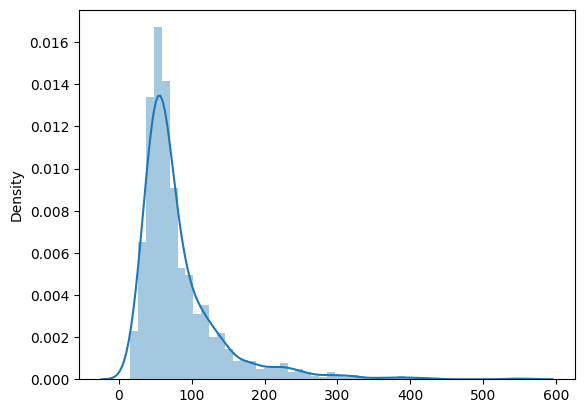

In [146]:
_, _,mse1, _, mean, std = predict_test(model, train_dataset)

sns.distplot(mse1, bins=50, kde=True);

In [147]:
np.mean(mse), np.std(mse)

(1.3790387, 2.5682132)

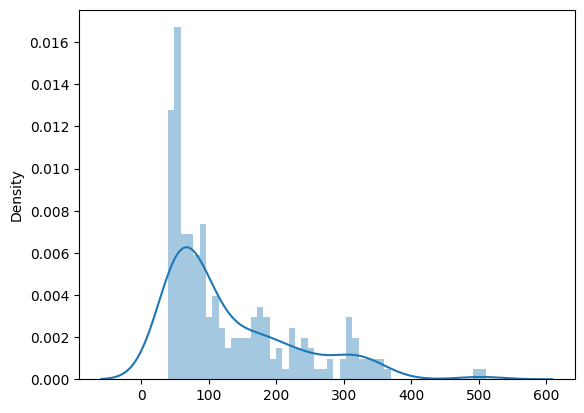

In [148]:
predictions, pred_losses, mse2, _, _, _ = predict_test(model, cluster2_dataset)
sns.distplot(mse2, bins=50, kde=True);

In [137]:
np.mean(mse), np.std(mse)

(1.3790387, 2.5682132)

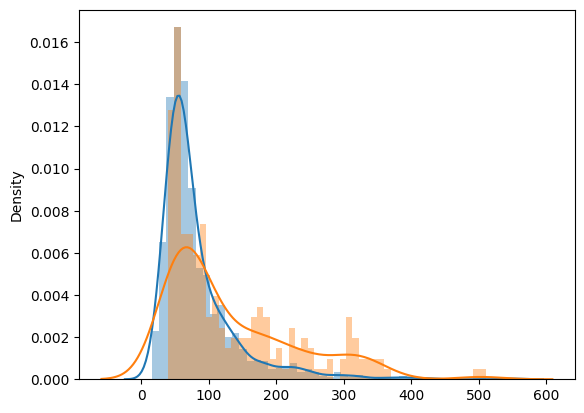

In [150]:
sns.distplot(mse1, bins=50, kde=True)
sns.distplot(mse2, bins=50, kde=True);


# =============

In [190]:
model

VAE_LSTM(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (z_mean): Linear(in_features=128, out_features=128, bias=True)
  (z_log_var): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [191]:
with torch.no_grad():
        model = model.train()
        for seq_true in train_dataset:
            seq_true = seq_true.to(device)
            seq_pred, encoded, mean, std = model(seq_true)
            break

In [197]:
std

tensor([[ 1.5200e-03, -1.6688e-03, -4.8611e-03, -3.2665e-03,  2.2281e-05,
         -1.8460e-03, -2.9268e-03,  2.8192e-03, -1.5426e-05, -4.8234e-04,
          8.3820e-04,  6.6859e-04, -5.3550e-03,  1.4338e-03, -3.9333e-03,
         -3.4924e-03, -1.1860e+00,  3.8121e-03,  3.6495e-03,  3.0647e-04,
          1.7868e-04, -8.1664e-04, -3.2397e-03,  4.0853e-04,  4.1988e-03,
         -3.0455e-03,  8.1403e-05, -3.9189e-03, -1.4461e-03, -2.6995e-03,
          3.2350e-03,  2.8010e-03, -7.1748e-03, -4.7361e-03,  1.4370e-04,
         -6.5135e-03, -3.2722e-03, -3.1949e-03, -3.6640e-03,  1.2221e-04,
          8.6151e-05,  3.0528e-03, -2.2457e-03, -2.5693e-03, -1.3554e-03,
         -6.9479e-04,  3.0644e-03,  2.2284e-03, -1.2965e-03, -1.5750e-04,
         -4.4727e-03,  7.5736e-04, -8.2472e-04, -6.8996e-05, -2.7770e-03,
         -1.1792e-03,  1.3717e-04, -1.2782e-03, -4.1482e-03, -2.3609e-03,
         -5.3784e-04, -6.8099e-04,  1.5231e-03,  2.8402e-03, -4.4412e-03,
          9.0774e-04, -5.2762e-04,  1.